In [1]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [2]:
from kaggle import api
from kaggle.api.kaggle_api_extended import KaggleApi
api = KaggleApi()
api.authenticate()

In [3]:
!kaggle datasets download -d fedesoriano/multijet-primary-dataset

Dataset URL: https://www.kaggle.com/datasets/fedesoriano/multijet-primary-dataset
License(s): CC0-1.0
  0% 0.00/1.09M [00:00<?, ?B/s]
100% 1.09M/1.09M [00:00<00:00, 115MB/s]


In [4]:
import zipfile
z=zipfile.ZipFile('/content/multijet-primary-dataset.zip','r')
z.extractall('/content')
z.close()

Data exploration

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
import warnings
warnings.filterwarnings('ignore')
#

In [13]:
df = pd.read_csv(r'/content/MultiJetRun2010B.csv')
df.head()

Run  Lumi      Event       MR       Rsq        E1      Px1        Py1  \
0  148029   388  302318745  215.553  0.031977  136.7100 -109.893  -54.03420   
1  148029   388  302323641  155.437  0.042157   83.3865   81.150    6.88361   
2  148029   388  302336217  400.563  0.026938  253.1840  139.902  102.64000   
3  148029   388  302382289  286.245  0.094192  175.4860 -156.024  -62.95350   
4  148029   388  302403873  204.514  0.018804  833.7950  100.410  -16.65900   

        Pz1        E2       Px2       Py2       Pz2       HT       MET  nJets  \
0  -58.9032  142.1790   70.0254  41.12250 -116.5130  203.666  18.31100      2   
1  -12.9688   73.9025  -72.2472  11.88350    3.0899  154.659  14.77470      2   
2 -101.9350  535.5510 -110.3790 -89.09290 -516.1790  343.280  25.22110      3   
3  -47.7434  112.8510   89.0843   3.45025   67.9007  257.397  46.02880      2   
4 -827.4980  445.6120  -91.1991  15.55830 -390.1440  269.492   8.11345      3   

   nBJets  
0       0  
1       0  
2       0  
3       0  
4       0

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21726 entries, 0 to 21725
Data columns (total 17 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Run     21726 non-null  int64  
 1   Lumi    21726 non-null  int64  
 2   Event   21726 non-null  int64  
 3   MR      21726 non-null  float64
 4   Rsq     21726 non-null  float64
 5   E1      21726 non-null  float64
 6   Px1     21726 non-null  float64
 7   Py1     21726 non-null  float64
 8   Pz1     21726 non-null  float64
 9   E2      21726 non-null  float64
 10  Px2     21726 non-null  float64
 11  Py2     21726 non-null  float64
 12  Pz2     21726 non-null  float64
 13  HT      21726 non-null  float64
 14  MET     21726 non-null  float64
 15  nJets   21726 non-null  int64  
 16  nBJets  21726 non-null  int64  
dtypes: float64(12), int64(5)
memory usage: 2.8 MB


In [9]:
df.isnull().sum().sum()

0

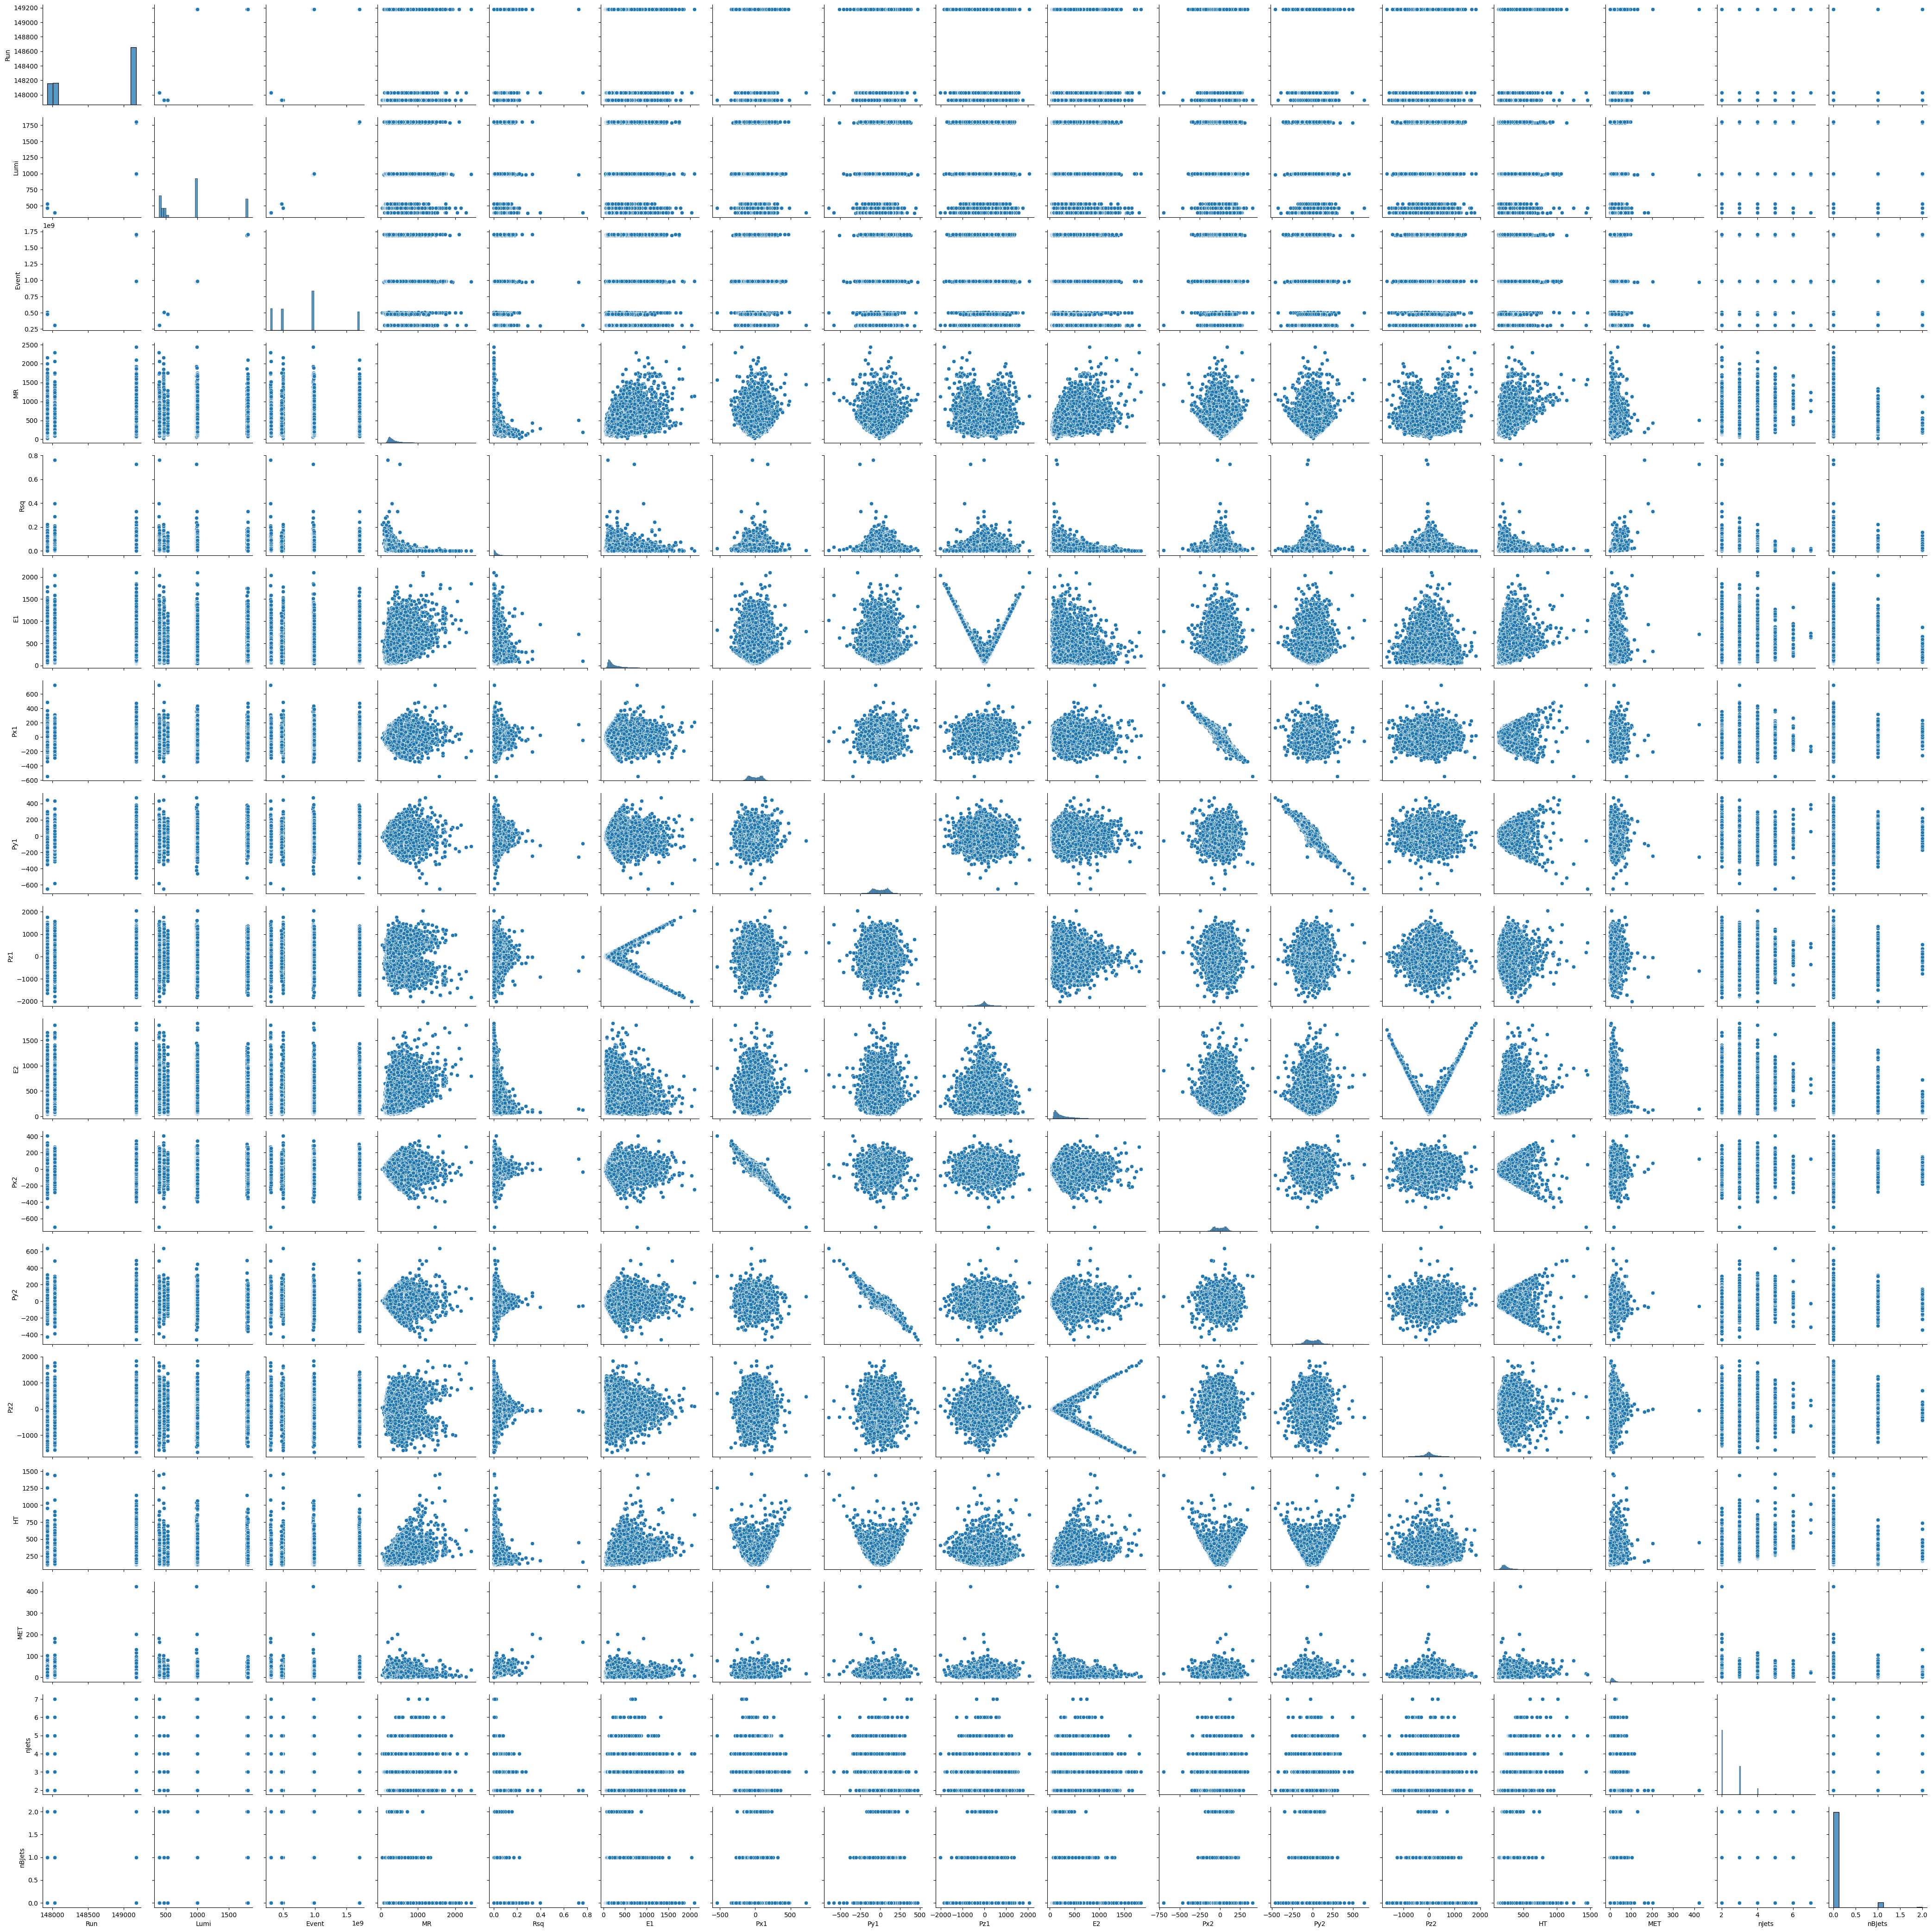

In [10]:
sb.pairplot(df)

In [11]:
# Display unique values for each column
for column in df.columns:
    unique_values = df[column].unique()
    print(f"Column: {column}")
    print(f"Unique Values: {unique_values}")
    print(f"Number of Unique Values: {len(unique_values)}\n")

Column: Run
Unique Values: [148029 147926 149181 147929]
Number of Unique Values: 4

Column: Lumi
Unique Values: [ 388  389  390  391  392  393  394  395  462  463  464  465  466  467
  985  986  991  992  997  998  999 1000  532 1788 1789 1802 1803 1804]
Number of Unique Values: 28

Column: Event
Unique Values: [ 302318745  302323641  302336217 ... 1703621104 1703642752 1703634776]
Number of Unique Values: 21726

Column: MR
Unique Values: [215.553 155.437 400.563 ... 484.392 215.713 547.384]
Number of Unique Values: 21129

Column: Rsq
Unique Values: [0.0319766  0.0421566  0.0269384  ... 0.00092047 0.0558359  0.00123236]
Number of Unique Values: 21487

Column: E1
Unique Values: [136.71    83.3865 253.184  ... 197.153  647.406  242.414 ]
Number of Unique Values: 21146

Column: Px1
Unique Values: [-109.893    81.15    139.902  ...  -61.5507  -78.9546  191.218 ]
Number of Unique Values: 21487

Column: Py1
Unique Values: [ -54.0342     6.88361  102.64    ...   21.7693   -88.7569  -118.758 

Data Preprocessing

In [14]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split

def preprocess_data(df, target_column='nJets', test_size=0.2, random_state=42):
    # Drop Run, Lumi, Event columns
    df = df.drop(columns=['Run', 'Lumi', 'Event'])

    # Separate the target column from features
    X = df.drop(columns=[target_column])
    y = df[target_column]

    # Identify categorical and numerical columns
    categorical_cols = X.select_dtypes(include=['int64', 'object']).columns.tolist()
    numerical_cols = X.select_dtypes(include=['float64']).columns.tolist()

    # If any numeric column should be treated as categorical
    for col in categorical_cols:
        if X[col].nunique() <= 10:  # Adjust the threshold as needed
            X[col] = X[col].astype('category')

    # Update categorical and numerical columns after conversion
    categorical_cols = X.select_dtypes(include=['category', 'object']).columns.tolist()
    numerical_cols = X.select_dtypes(include=['float64']).columns.tolist()

    # Define preprocessing for numerical data
    numerical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ])
    print(f'Categorical columns: {categorical_cols}')
    print(f'Numerical columns: {numerical_cols}')

    # Define preprocessing for categorical data
    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ])

    # Combine preprocessing steps
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numerical_transformer, numerical_cols),
            ('cat', categorical_transformer, categorical_cols)
        ])

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

    # Fit and transform the training data, and transform the test data
    X_train_preprocessed = preprocessor.fit_transform(X_train)
    X_test_preprocessed = preprocessor.transform(X_test)

    return X_train_preprocessed, X_test_preprocessed, y_train, y_test, preprocessor

X_train_preprocessed, X_test_preprocessed, y_train, y_test, preprocessor = preprocess_data(df)

Categorical columns: ['nBJets']
Numerical columns: ['MR', 'Rsq', 'E1', 'Px1', 'Py1', 'Pz1', 'E2', 'Px2', 'Py2', 'Pz2', 'HT', 'MET']


In [20]:
print(f'X_train_preprocessed shape: {X_train_preprocessed.shape}')
print(f'X_test_preprocessed shape: {X_test_preprocessed.shape}')
print(f'y_train shape: {y_train.shape}')
print(f'y_test shape: {y_test.shape}')

X_train_preprocessed shape: (17380, 15)
X_test_preprocessed shape: (4346, 15)
y_train shape: (17380,)
y_test shape: (4346,)


Model training and testing

In [35]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, classification_report
from sklearn.model_selection import cross_val_score
import pickle

def train_and_evaluate(X_train, X_test, y_train, y_test, model_filename='random_forest_model1.pkl'):
    # Initialize and train the Random Forest model
    model = RandomForestClassifier(n_estimators=1000, random_state=42)
    model.fit(X_train, y_train)

    # Make predictions on the test set
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)  # For multiclass classification
    print(f'y_pred: {y_pred}')
    print(f'y_pred_unique: {np.unique(y_pred)} ')
    print(f'y_pred_proba: {y_pred_proba}')

    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred)

    # Generate the classification report
    report = classification_report(y_test, y_pred, output_dict=True)

    # Convert the report to a DataFrame
    report_df = pd.DataFrame(report).transpose()

    # Calculate ROC AUC score (for multiclass classification)
    auc_roc = roc_auc_score(y_test, y_pred_proba, multi_class='ovr')

    # Print accuracy and AUC ROC score
    print(f'Accuracy: {accuracy:.4f}')
    print(f'AUC ROC Score: {auc_roc:.4f}')

    # Calculate ROC curves and plot for each class
    n_classes = y_pred_proba.shape[1]
    plt.figure(figsize=(12, 8))

    for i in range(n_classes):
        fpr, tpr, _ = roc_curve(y_test, y_pred_proba[:, i], pos_label=i)
        plt.plot(fpr, tpr, label=f'ROC curve for class {i}')

    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve for Each Class')
    plt.legend(loc='best')
    plt.grid(True)
    plt.show()

    # Display the classification report
    display(report_df)

    # Save the model to a file using pickle
    with open(model_filename, 'wb') as file:
        pickle.dump(model, file)
    print(f'Model saved to {model_filename}')

    return model, accuracy, auc_roc

y_pred: [2 2 3 ... 2 2 2]
y_pred_unique: [2 3 4] 
y_pred_proba: [[0.571 0.358 0.045 0.026 0.    0.   ]
 [0.512 0.325 0.129 0.033 0.001 0.   ]
 [0.328 0.357 0.291 0.019 0.005 0.   ]
 ...
 [0.894 0.106 0.    0.    0.    0.   ]
 [0.845 0.153 0.001 0.001 0.    0.   ]
 [0.834 0.149 0.016 0.001 0.    0.   ]]
Accuracy: 0.7736
AUC ROC Score: 0.9314


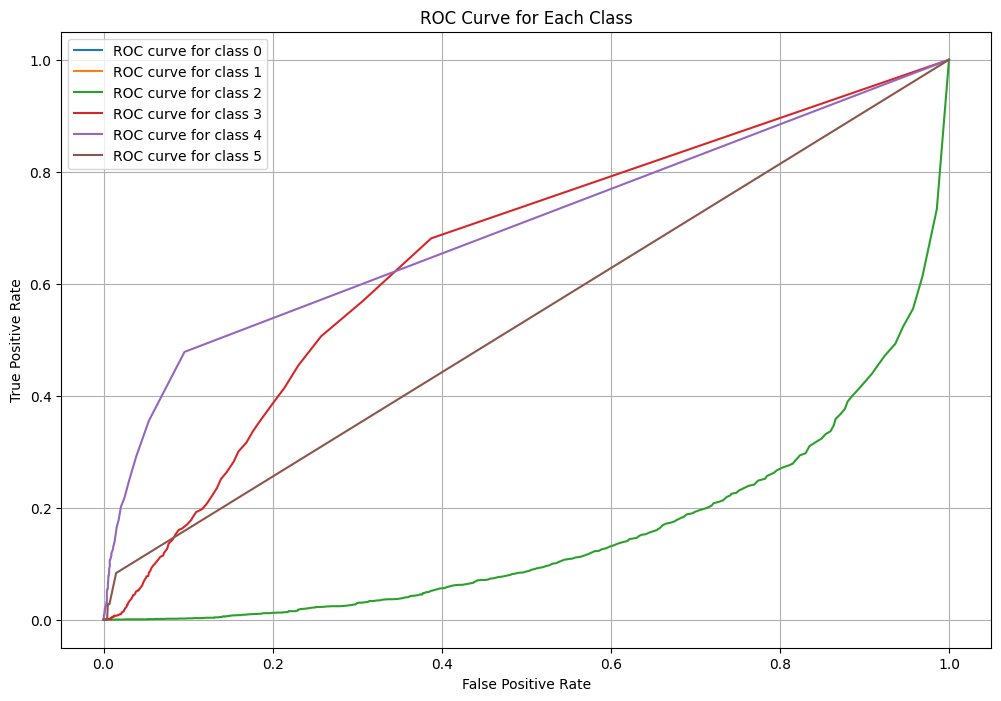

precision    recall  f1-score      support
2              0.817819  0.944306  0.876523  2819.000000
3              0.656126  0.540277  0.592593  1229.000000
4              0.455696  0.142292  0.216867   253.000000
5              0.000000  0.000000  0.000000    36.000000
6              0.000000  0.000000  0.000000     8.000000
7              0.000000  0.000000  0.000000     1.000000
accuracy       0.773585  0.773585  0.773585     0.773585
macro avg      0.321607  0.271146  0.280997  4346.000000
weighted avg   0.742545  0.773585  0.748753  4346.000000

Model saved to random_forest_model1.pkl


In [36]:
model, accuracy, auc_roc = train_and_evaluate(X_train_preprocessed, X_test_preprocessed, y_train, y_test)